In [19]:
from scipy import misc
import imageio
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
from skimage.io import imread_collection
from scipy import ndimage


#image path 
noisy_dir = 'Dataset/Noisy/*.jpg'

#creating a collection with the available images
noisy = imread_collection(noisy_dir)

In [20]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

array([[[164, 177, 186],
        [164, 177, 186],
        [164, 177, 186],
        ...,
        [161, 178, 188],
        [161, 178, 188],
        [159, 176, 186]],

       [[162, 175, 184],
        [163, 176, 185],
        [163, 176, 185],
        ...,
        [162, 179, 189],
        [162, 179, 189],
        [161, 178, 188]],

       [[163, 176, 185],
        [163, 176, 185],
        [163, 176, 185],
        ...,
        [160, 177, 187],
        [160, 177, 187],
        [161, 178, 188]],

       ...,

       [[ 48,  93, 122],
        [ 56, 101, 130],
        [ 37,  82, 111],
        ...,
        [213, 203, 194],
        [218, 208, 199],
        [221, 208, 200]],

       [[ 30,  75, 104],
        [ 35,  80, 109],
        [ 50,  95, 124],
        ...,
        [171, 164, 154],
        [178, 169, 160],
        [178, 169, 160]],

       [[ 43,  88, 117],
        [ 43,  88, 117],
        [ 51,  96, 125],
        ...,
        [166, 159, 149],
        [174, 167, 157],
        [175, 166, 157]]

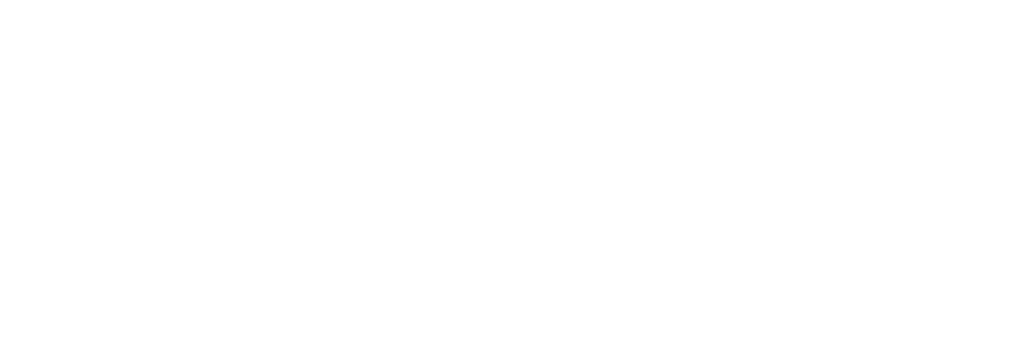

In [21]:
plt.figure(figsize=(18, 6))
plt.axis('off')
noisy[0]

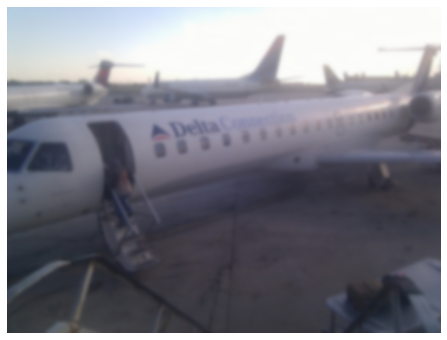

In [22]:
k = np.array([[0,0,0],[0,1,0],[0,0,0]])

def noisyTreatment(image):
    red = image[:, :, 0]
    gauss_denoised_red = ndimage.gaussian_filter(red, sigma=2.5)
    fred = scipy.ndimage.convolve(gauss_denoised_red, k, mode='constant', cval=0.0)

    green = image[:, :, 1]
    gauss_denoised_green = ndimage.gaussian_filter(green, sigma=2.5)
    fgreen = scipy.ndimage.convolve(gauss_denoised_green, k, mode='constant', cval=0.0)

    blue = image[:, :, 2]
    gauss_denoised_blue = ndimage.gaussian_filter(blue, sigma=2.5)
    fblue = scipy.ndimage.convolve(gauss_denoised_blue, k, mode='constant', cval=0.0)

    return np.dstack((fred, fgreen, fblue))

truc = noisyTreatment(noisy[1])
plt.figure(figsize=(18, 6))
plt.axis('off')

k = np.array([[0,0,0],[0,1,0],[0,0,0]])
plt.imshow(truc)
